In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
zthree = ["a=0.1588","a=0.1590","a=0.1593"]
zfour = ["a=0.1566","a=0.1570","a=0.1569"]
zfive = ["a=0.1540","a=0.1544","a=0.1539"]
zsix = ["a=0.1515","a=0.1518","a=0.1519"]
zseven = ["a=0.1499","a=0.1493","a=0.1500"]
zeight = ["a=0.1476","a=0.1477","a=0.1472"]
znine = ["a=0.1452","a=0.1453"]
zsix_zero =["a=0.1430","a=0.1429","a=0.1435"]
zsix_one = ["a=0.1400","a=0.1409","a=0.1401"]

In [113]:
def load_and_process_files(directory, res_files, valid_start_chars, target_files):
    all_data = []
    for subdir in os.listdir(directory):
        if subdir[0] in valid_start_chars:
            subdir_path = os.path.join(directory, subdir)
            if os.path.isdir(subdir_path):
                for file_name in target_files:
                    for res_file in res_files:
                        file_path = os.path.join(subdir_path, file_name, res_file)
                        if os.path.isfile(file_path):
                            df = pd.read_csv(file_path, delimiter=' ')
                            all_data.append(df)
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df.rename(columns={'#': 'tau', '<tau>': 'length', 'length[km/s]': 'km_per_s'}, inplace=True)
    combined_df.drop(columns=['km_per_s', 'length'], inplace=True)
    all_tau_values = -np.log(combined_df.values.flatten())
    return all_tau_values

def split_data(all_tau_values, testsize):
    if testsize == 0:
        return all_tau_values, []
    elif testsize == 1:
        return [], all_tau_values
    else:
        train, test = train_test_split(all_tau_values, test_size=testsize, shuffle=True, random_state=100)
        return train, test

def redshift(directory, res_files, valid_start_chars, target_files, testsize, 
             target_files_two, testsize2, target_files_three, testsize3, 
             return_train1=False, return_train2=False, return_train3=True, num_samples=1000):
    
    all_tau_values = load_and_process_files(directory, res_files, valid_start_chars, target_files)
    all_tau_second = load_and_process_files(directory, res_files, valid_start_chars, target_files_two)
    all_tau_third = load_and_process_files(directory, res_files, valid_start_chars, target_files_three)
    
    train1, test1 = split_data(all_tau_values, testsize)
    train2, test2 = split_data(all_tau_second, testsize2)
    train3, test3 = split_data(all_tau_third, testsize3)
    
    result1 = train1 if return_train1 else test1
    result2 = train2 if return_train2 else test2
    result3 = train3 if return_train3 else test3
    
    return result1, result2, result3
direc = r'C:\Users\eawer\Downloads\C40-20240625T140952Z-001\C40'
redshift(direc,["avgflux.x50.res"],['A','C','F'],zsix_one,.5,zsix_zero,1,znine,.5)

C:\Users\eawer\AppData\Local\Temp\ipykernel_22484\1868542742.py:16: RuntimeWarning: divide by zero encountered in log
  all_tau_values = -np.log(combined_df.values.flatten())


(array([4.54595833, 4.22673375, 5.8168392 , ..., 7.55707698, 4.4498773 ,
        4.57173541]),
 array([4.38442952, 4.75727296, 3.57733808, ..., 7.00250562, 5.28067393,
        6.75847358]),
 array([2.93670893, 6.27914662, 4.61269845, ..., 3.59138983, 5.06577809,
        3.73136951]))

In [114]:
def cdf_redshift(los, combined_annotation, xy_position, num_samples=1000):
    one = np.linspace(0, 1, los)
    q25_arr, q75_arr, q50_arr, q5_arr, q95_arr = [], [], [], [], [] #min_tau
    tau_samples = []
    tau1,tau2,tau3 =redshift(direc,["avgflux.x50.res"],['A','C','F'],zsix_one,.5,zsix_zero,1,znine,.5)
    tau_combined = np.concatenate((tau1,tau2,tau3))

    for _ in range(num_samples):
        sample = np.random.choice(tau_combined, los, replace=False)
        sample.sort()
        tau_samples.append(sample)

    for i in range(los):
        tau_1 = [sample[i] for sample in tau_samples]
        tau_1 = np.array(tau_1)
        q25 = np.quantile(tau_1, .25)
        q75 = np.quantile(tau_1, .75)
        q50 = np.quantile(tau_1, .5)
        q5 = np.quantile(tau_1, .05)
        q95 = np.quantile(tau_1, .95)
        q50_arr.append(q50)
        q25_arr.append(q25)
        q75_arr.append(q75)
        q5_arr.append(q5)
        q95_arr.append(q95)
    plt.plot(q50_arr, one, label='Median', color='black')
    #cdf_second(r'C:\Users\eawer\Downloads\C40-20240625T140952Z-001\C40',["avgflux.x50.res"],["a=0.1540","a=0.1544","a=0.1539"],['A','C','F'],10,'z=5.5',(3.5, .2))
    plt.fill_betweenx(one, q25_arr, q75_arr, color='gray', alpha=0.5, label='25% to 75%')
    plt.fill_betweenx(one, q5_arr, q95_arr, color='gray', alpha=0.2, label='5% to 95%')
    plt.xlabel(r'$\langle \tau_{\mathrm{GP}} \rangle_{50}$', fontsize=20)
    plt.ylabel(r'P(> $\langle \tau_{\mathrm{GP}} \rangle_{50}$)', fontsize=20)
    plt.xlim([0,5])
    bbox_props = dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white")
    plt.annotate(combined_annotation, xy=xy_position, bbox=bbox_props, ha='center', va='center')
    #plt.legend(loc='upper right')

In [125]:
def obs(file, redshift,combined_annotation,xy_pos,xlim):
    df = pd.read_csv(file)
    df['Tau'] = df['Tau'].astype(str).fillna('') 
    df['<Z>'] = pd.to_numeric(df['<Z>'], errors='coerce')
    df = df[~df['Tau'].str.contains('nan')]  
    df = df.sort_values(by='<Z>') 
    df = df.drop(['QUASAR', 'QUASAR Z'], axis=1)
    df1 = df.copy()
    df['Tau'] = df['Tau'].str.replace('> ', '') 
    df['Tau'] = pd.to_numeric(df['Tau'], errors='coerce')
    
    obs_list_3858= [] #one that's normal
    for z_min, z_max in redshift:
        obs_df = df[(df['<Z>'] >= z_min) & (df['<Z>'] <= z_max)]
        obs_df = obs_df.sort_values(by='Tau')
        obs_df_3858 = obs_df
        obs_list_3858.append(obs_df_3858)
    obs_list_new = [] #the one that replaces
   
    for z_min, z_max in redshift: #the one that replaces
        obs_df1 = df1[(df1['<Z>'] >= z_min) & (df1['<Z>'] <= z_max)]
        tau_values = obs_df1[obs_df1['Tau'].str.contains('> ', na=False)]
        tau_list = tau_values.index.tolist()
        for index in tau_list:
            obs_df1.at[index, 'Tau'] = '1000'
        obs_list_new.append(obs_df1)
        print(len(obs_df1))
    prob_list_3858 = []
    for obs_df_3858 in obs_list_3858:
        
        obs_df_3858['Tau'] = pd.to_numeric(obs_df_3858['Tau'], errors='coerce')
        initial_row = pd.DataFrame({'Tau': [0]})
        end_row = pd.DataFrame({'Tau':[100]})
        bins_arr = pd.concat([initial_row,obs_df_3858,end_row],ignore_index=True)
        hist, bins = np.histogram(obs_df_3858['Tau'], bins=bins_arr['Tau'])
        cumulative_counts = np.cumsum(hist)
        prob = cumulative_counts / len(obs_df_3858)
        prob_df_3858 = pd.DataFrame({
            'tau': bins[:-1],
            'probability': prob
        })
        initial_row = pd.DataFrame({'tau': [0],'probability': [0] })
        prob_df_3858 = pd.concat([initial_row,prob_df_3858],ignore_index=True)
        prob_list_3858.append(prob_df_3858)
    
    prob_list_new = []
    for obs_df_new in obs_list_new:
        obs_df_new['Tau'] = pd.to_numeric(obs_df_new['Tau'], errors='coerce')
        hist, bins_new = np.histogram(obs_df_new['Tau'], bins=bins)
        cumulative_counts = np.cumsum(hist)
        prob = cumulative_counts / len(obs_df_new['Tau'])
        prob_df_new = pd.DataFrame({
            'tau': bins_new[:-1],
            'probability': prob
        })
        initial_row = pd.DataFrame({'tau': [0],'probability': [0] })
        prob_df_new = pd.concat([initial_row,prob_df_new],ignore_index=True)
        prob_list_new.append(prob_df_new) 
        
    # Plotting
    plt.figure(figsize=(10, 5))
    
    for prob_df_3858 in prob_list_3858:
        plt.plot(prob_df_3858['tau'], prob_df_3858['probability'], linestyle='--', color='blue', label='Bosman et al. 2018')

    for prob_df_new in prob_list_new:
        plt.plot(prob_df_new['tau'], prob_df_new['probability'], linestyle='--',color='blue')

        plt.fill_between(prob_df_3858['tau'], prob_df_3858['probability'], prob_df_new['probability'], color='blue',hatch='///', alpha=0.5)
    bbox_props = dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white")
    cdf_redshift(11,'z=5.3 & z=5.4',(4, 10))
    plt.annotate(combined_annotation, xy=xy_pos,  # Adjust xy position as needed
             bbox=bbox_props, ha='center', va='center',fontsize=16)
    plt.xlim([2.5, xlim])  # Adjust as needed
    plt.xlabel(r'$\langle \tau_{\mathrm{GP}} \rangle_{50}$', fontsize=23)
    plt.ylabel(r'P(> $\langle \tau_{\mathrm{GP}} \rangle_{50}$)', fontsize=23)
    plt.tick_params(axis='both', which='major', labelsize=20) 
    #plt.legend(fontsize=18)
    plt.show()


11


C:\Users\eawer\AppData\Local\Temp\ipykernel_22484\114391402.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_df_new['Tau'] = pd.to_numeric(obs_df_new['Tau'], errors='coerce')
C:\Users\eawer\AppData\Local\Temp\ipykernel_22484\1868542742.py:16: RuntimeWarning: divide by zero encountered in log
  all_tau_values = -np.log(combined_df.values.flatten())


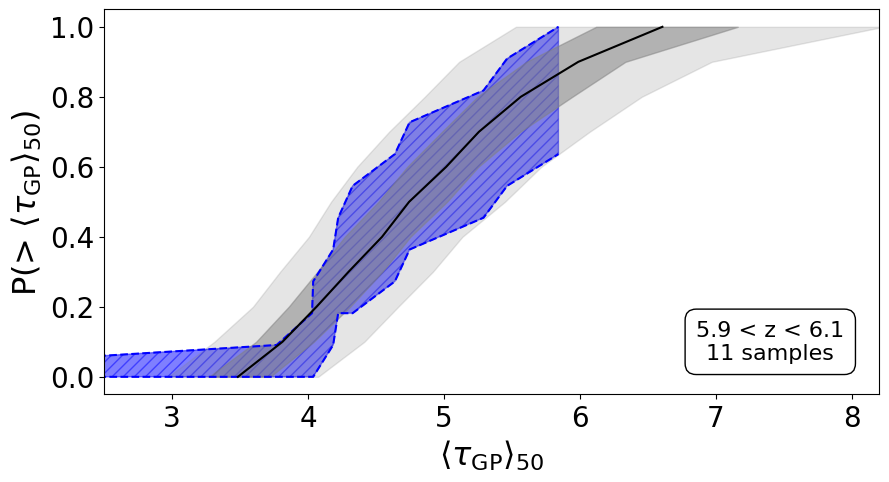

In [128]:
obs('alldata_silver.csv',[(5.9,6.1)],'5.9 < z < 6.1\n11 samples',(7.4,.1),8.2)